<a href="https://colab.research.google.com/github/aniketSanyal/GamesInMLProject/blob/main/Symplectic_Gradient_Adjustment_with_Lookahead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import copy
from time import time

# Section 1

## Defining the optimizers (including the Symplectic Gradient Adjustment Optimizer) for empirical comparisons

In [65]:
def init_th(dims, std):
  th = []
  for i in range(len(dims)):
    if std > 0:
      init = torch.nn.init.normal_(torch.empty(dims[i], requires_grad=True), std=std)
    else:
      init = torch.zeros(dims[i], requires_grad=True)
    th.append(init)
  return th

def get_gradient(function, param):
  grad = torch.autograd.grad(function, param, create_graph=True)[0]
  return grad

def get_hessian(th, grad_L, diag=True, off_diag=True):
  n = len(th)
  H = []
  for i in range(n):
    row_block = []
    for j in range(n):
      if (i == j and diag) or (i != j and off_diag):
        block = [torch.unsqueeze(get_gradient(grad_L[i][i][k], th[j]), dim=0)
                  for k in range(len(th[i]))]
        row_block.append(torch.cat(block, dim=0))
      else:
        row_block.append(torch.zeros(len(th[i]), len(th[j])))
    H.append(torch.cat(row_block, dim=1))
  return torch.cat(H, dim=0)


def update_th(th, Ls, alpha, algo, a=0.5, b=0.1, gam=0.1, ep=0.1, lss_lam=0.1):
  n = len(th)
  losses = Ls(th)

  grad_L = [[get_gradient(losses[j], th[i]) for j in range(n)] for i in range(n)]
  if algo == 'sga':
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    ham = torch.dot(xi, xi.detach())
    H_t_xi = [get_gradient(ham, th[i]) for i in range(n)]
    H_xi = [get_gradient(sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
              for j in range(n)]), th[i]) for i in range(n)]
    A_t_xi = [H_t_xi[i]/2-H_xi[i]/2 for i in range(n)]
    dot_xi = torch.dot(xi, torch.cat(H_t_xi))
    dot_A = torch.dot(torch.cat(A_t_xi), torch.cat(H_t_xi))
    d = sum([len(th[i]) for i in range(n)])
    lam = torch.sign(dot_xi*dot_A/d+ep)
    grads = [grad_L[i][i]+lam*A_t_xi[i] for i in range(n)]
  elif algo =='improved-sga':
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    ham = torch.dot(xi, xi.detach())
    H_t_xi = [get_gradient(ham, th[i]) for i in range(n)]
    H_xi = [get_gradient(sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
              for j in range(n)]), th[i]) for i in range(n)]
    A_t_xi = [H_t_xi[i]/2-H_xi[i]/2 for i in range(n)]
    S_t_xi = [H_t_xi[i]/2+H_xi[i]/2 for i in range(n)]

    dot_xi = torch.dot(xi, torch.cat(H_t_xi))
    dot_A = torch.dot(torch.cat(A_t_xi), torch.cat(H_t_xi))

    dot_S = torch.dot(torch.cat(S_t_xi), torch.cat(H_t_xi))

    d = sum([len(th[i]) for i in range(n)])
    lam_S = torch.sign(dot_xi*dot_S/d+ep)

    lam = torch.sign(dot_xi*dot_A/d+ep)
    grads = [grad_L[i][i]+lam*A_t_xi[i] + lam_S*S_t_xi[i] for i in range(n)]
  elif algo == 'eg':
    th_eg = [th[i]-alpha*get_gradient(losses[i], th[i]) for i in range(n)]
    losses_eg = Ls(th_eg)
    grads = [get_gradient(losses_eg[i], th_eg[i]) for i in range(n)]
  elif algo == 'ham':
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    ham = torch.dot(xi, xi.detach())
    grads = [get_gradient(ham, th[i]) for i in range(n)]
  elif algo == 'co':
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    ham = torch.dot(xi, xi.detach())
    grads = [grad_L[i][i]+gam*get_gradient(ham, th[i]) for i in range(n)]
  else:
    grads = [grad_L[i][i] for i in range(n)]

  with torch.no_grad():
    for i in range(n):
      th[i] -= alpha*grads[i]
  return th, losses, grads

In [3]:
#simple func to calculate distance to optimum
def calculate_l2_distance(x, y, x_soln =0,  y_soln=0):
    return np.sqrt((x-x_soln)**2 + (y-y_soln)**2)


In [4]:
def lookahead(points, gradient_func, num_iters, step_size,k=5, alpha=.5, solution =(0,0)):

  x, y = points[0],points[1]
  x_prev, y_prev = x.clone().detach(), y.clone().detach()
  trajectory = []
  distance_to_optimum =[]

  for i in range(num_iters):
    if i>0 and i%k ==0:
      x = (1-alpha)*x_prev + alpha * x
      y = (1-alpha)*y_prev + alpha * y
      #updating the lookahead step
      x_prev, y_prev = x.clone().detach(), y.clone().detach()


    th = [x,y]
    #regular gd step
    x_grad, y_grad = gradient_func(th)

    y = y - step_size * y_grad[0]
    x = x - step_size * x_grad[0]

    distance_to_optimum.append(calculate_l2_distance(x.clone().detach().numpy(),y.clone().detach().numpy(), solution[0], solution[1]))
    trajectory.append((x, y))

  return trajectory, distance_to_optimum

## Defining the problem : Matched Pennies

We start with a simple and popular problem - matching pennies. The Nash Equilibrium is at (0,0)

In [39]:
def matching_pennies():
  dims = [1, 1]
  payout_mat_1 = torch.Tensor([[1,-1],[-1,1]])
  payout_mat_2 = -payout_mat_1
  def Ls(th):
    p_1, p_2 = torch.sigmoid(th[0]), torch.sigmoid(th[1])
    x, y = torch.cat([p_1, 1-p_1]), torch.cat([p_2, 1-p_2])
    L_1 = torch.matmul(torch.matmul(x, payout_mat_1), y)
    L_2 = torch.matmul(torch.matmul(x, payout_mat_2), y)
    return [L_1, L_2]
  return dims, Ls

In [40]:
#this gradient func is explicitly calculated for the matching pennies problem to help the lookahead method
payout_mat_1 = torch.Tensor([[1,-1],[-1,1]])
payout_mat_2 = -payout_mat_1
def gradient_func(th):
  p_1, p_2 = torch.sigmoid(th[0]), torch.sigmoid(th[1])
  x, y = torch.cat([p_1, 1-p_1]), torch.cat([p_2, 1-p_2])
  grad_x = payout_mat_1.t() @ y
  grad_y = x.t() @ payout_mat_2
  return grad_x, grad_y


Running different Algorithms on Matching Pennies Problem

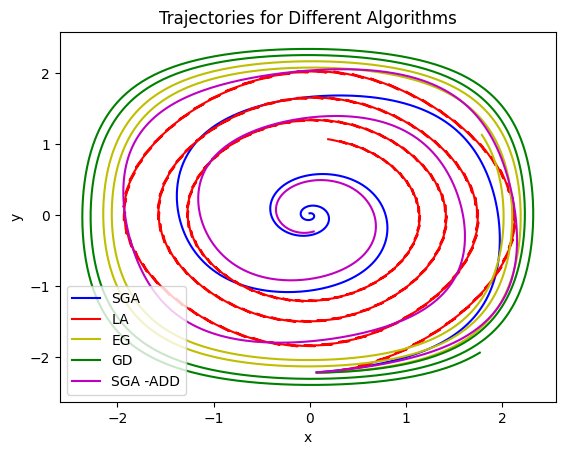

In [47]:
def run_and_plot(algo, th, Ls, num_epochs=1000, alpha=0.1, solution=(0,0)):
    th = [tensor.clone().detach().requires_grad_(True) for tensor in th]

    # Run
    losses_out = np.zeros((num_epochs, len(th)))
    th_out = []
    distances = []
    for k in range(num_epochs):
        th, losses,_ = update_th(th, Ls, alpha, algo)
        th_out.append(copy.deepcopy(th))
        losses_out[k] = [loss.data.numpy() for loss in losses]
        x , y = th[0].item(), th[1].item()
        distance_to_optimum = calculate_l2_distance(x,y, solution[0], solution[1])
        distances.append(distance_to_optimum)

    th_out_x = [th[0].item() for th in th_out]
    th_out_y = [th[1].item() for th in th_out]

    return th_out_x, th_out_y, losses_out, distances


dims, Ls = matching_pennies()
std = 1
th_initial = init_th(dims, std)


# Run and plot for 'sga'
th_out_x_sga, th_out_y_sga, losses_out_sga, distances_sga = run_and_plot('sga', th_initial, Ls)
plt.plot(th_out_x_sga, th_out_y_sga,linestyle='-', color='b', label='SGA')

trajectory, distances_la = lookahead(th_initial,gradient_func, 1000, 0.1)
x_values = [point[0].item() for point in trajectory]
y_values = [point[1].item() for point in trajectory]
plt.plot(x_values, y_values, linestyle='-', color='r', label = 'LA')

# Run and plot for 'eg'
th_out_x_eg, th_out_y_eg, losses_out_eg, distances_eg = run_and_plot('eg', th_initial, Ls)
plt.plot(th_out_x_eg, th_out_y_eg, linestyle='-', color='y', label='EG')


# Run and plot for 'gd'
th_out_x_gd, th_out_y_gd, losses_out_gd, distances_gd  = run_and_plot('gd', th_initial, Ls)
plt.plot(th_out_x_gd, th_out_y_gd, linestyle='-', color='g', label='GD')

th_out_x_sga_add, th_out_y_sga_add, losses_out_sga_add, distances_sga_add = run_and_plot('sga-add', th_initial, Ls)
plt.plot(th_out_x_sga_add, th_out_y_sga_add,linestyle='-', color='m', label='SGA -ADD')

plt.title('Trajectories for Different Algorithms')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

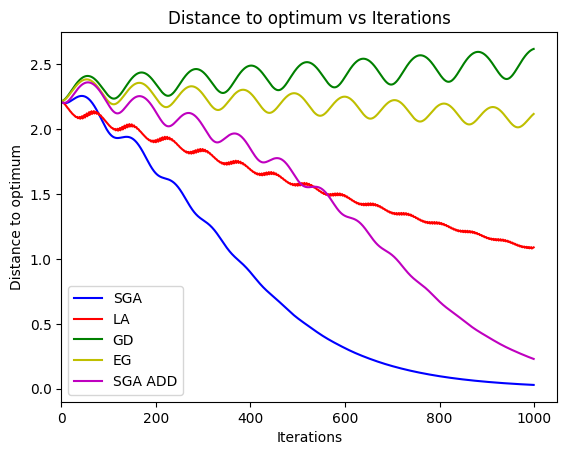

In [48]:
plt.plot(distances_sga, linestyle='-', color='b', label='SGA')
plt.plot(distances_la,  linestyle='-', color='r', label='LA')
plt.plot(distances_gd,linestyle='-', color='g', label='GD')
plt.plot(distances_eg,linestyle='-', color='y', label='EG')
plt.plot(distances_sga_add,linestyle='-', color='m', label='SGA ADD')

plt.title("Distance to optimum vs Iterations")
plt.xlim(left=0)
plt.xlabel("Iterations")
plt.ylabel("Distance to optimum")
plt.legend()
plt.show()

We see that SGA clearly outperforms LA and EG and GD(obviously) for the matching pennies

# Section 2

## Potential and Hamiltonian Games


The Hessian of the function H can be split into a symmetric (S) and a non-symmetric (A) part, where H= S+A.  A potential game is where S =0, whereas a Hamiltonian game is where A = 0. We now wish to investigate the performance of SGA against the other techniques in both these scenarios

We consider the following loss functions for our example of a Hamiltonian game (note: not a zero sum game)

$l_1 = x(y-b)$ and $l_2 = -(x-a)y$

The optimal solution of the above game is at (a,b)

The Hessian of the above function is as follows
$$
\mathbf{H} =
\begin{bmatrix}
    0 & 1 \\
    -1 & 0 \\
\end{bmatrix}
$$

this is clearly assymetric, hence S=0 and it is a hamiltonian game


In [55]:
def hamiltonian_game(a, b):
  dims = [1,1]
  def Ls(th):
    x , y = th[0], th[1]
    L_1 = torch.matmul(x, (y-b))
    L_2 = -torch.matmul(x-a, y)
    return [L_1, L_2]
  return dims, Ls

In [56]:
def gradient_for_Hamiltonian(th, a=1,b=1):
  grad_x = th[1]-b
  grad_y = -(th[0]-a)
  return grad_x, grad_y

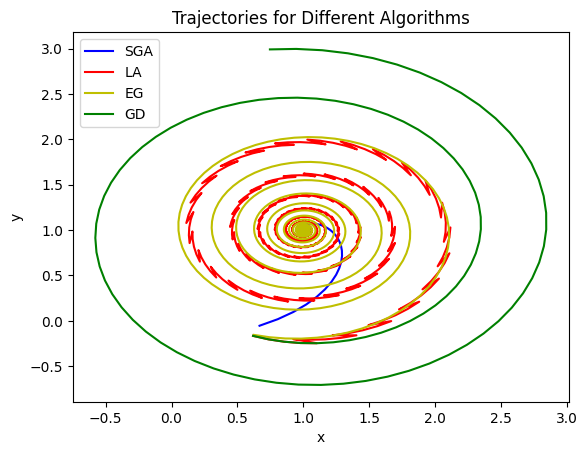

In [57]:
#We initial the game with a=1, b= 1
game_dims, game_Ls = hamiltonian_game(1,1)
th_initial = init_th(game_dims, std)

th_out_x_sga, th_out_y_sga, losses_out_sga, distances_sga = run_and_plot('sga', th_initial, game_Ls, solution=(1,1))
plt.plot(th_out_x_sga, th_out_y_sga,linestyle='-', color='b', label='SGA')

trajectory, distances_la = lookahead(th_initial,gradient_for_Hamiltonian, 1000, 0.1, solution=(1,1))
x_values = [point[0].item() for point in trajectory]
y_values = [point[1].item() for point in trajectory]
plt.plot(x_values, y_values, linestyle='-', color='r', label = 'LA')

# Run and plot for 'eg'
th_out_x_eg, th_out_y_eg, losses_out_eg, distances_eg = run_and_plot('eg', th_initial, game_Ls,solution=(1,1))
plt.plot(th_out_x_eg, th_out_y_eg, linestyle='-', color='y', label='EG')


# Run and plot for 'gd'
th_out_x_gd, th_out_y_gd, losses_out_gd, distances_gd  = run_and_plot('gd', th_initial, game_Ls,solution=(1,1))
plt.plot(th_out_x_gd[:100], th_out_y_gd[:100], linestyle='-', color='g', label='GD')

th_out_x_sga_add, th_out_y_sga_add, losses_out_sga_add, distances_sga_add = run_and_plot('sga-add', th_initial, Ls)



plt.title('Trajectories for Different Algorithms')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

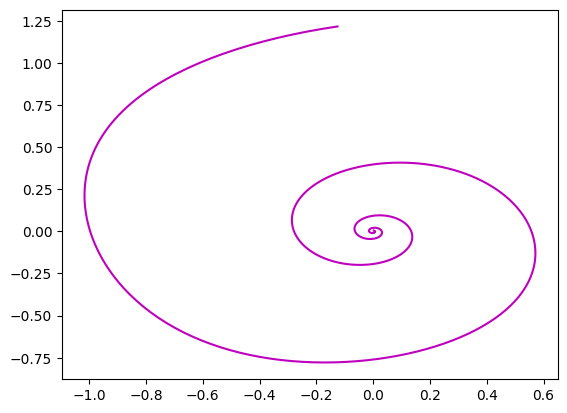

In [50]:
plt.plot(th_out_x_sga_add, th_out_y_sga_add,linestyle='-', color='m', label='SGA -ADD')

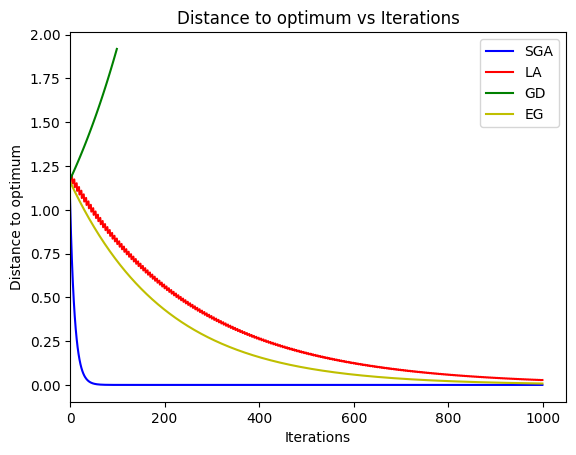

In [12]:
plt.plot(distances_sga, linestyle='-', color='b', label='SGA')
plt.plot(distances_la,  linestyle='-', color='r', label='LA')
plt.plot(distances_gd[:100],linestyle='-', color='g', label='GD')
plt.plot(distances_eg,linestyle='-', color='y', label='EG')

plt.title("Distance to optimum vs Iterations")
plt.xlim(left=0)
plt.xlabel("Iterations")
plt.ylabel("Distance to optimum")
plt.legend()
plt.show()


**Clearly for Hamiltonian games, SGA achieves optimum way before other techniques.**


Next we consider the case of potential games

We consider the following potential game

$$
l_1 = (x^2 + y^2),
l_2 = -(x^2+y^2)
$$

The optimum solution of the game is at (0,0)

The Hessian of the above function is as follows
$$
\mathbf{H} =
\begin{bmatrix}
    2 & 0 \\
    0 & -2 \\
\end{bmatrix}
$$

this is clearly symetric, hence A=0 and it is a potential game

**Note** The matching pennies problem is also a potential game (with a Nash Equilibrium)

In [13]:
def potential_game():
  dims = [1,1]
  def Ls(th):
    x , y = th[0], th[1]
    L_1 = x.t() @x + y.t() @y
    L_2 = -(x.t() @x + y.t() @y)
    return [L_1, L_2]
  return dims, Ls

In [14]:
def gradient_for_Hamiltonian(th):
  grad_x = 2*th[0]
  grad_y = -2*th[1]
  return grad_x, grad_y

<ipython-input-3-8bc7b4f0da70>:3: RuntimeWarning: overflow encountered in square
  return np.sqrt((x-x_soln)**2 + (y-y_soln)**2)


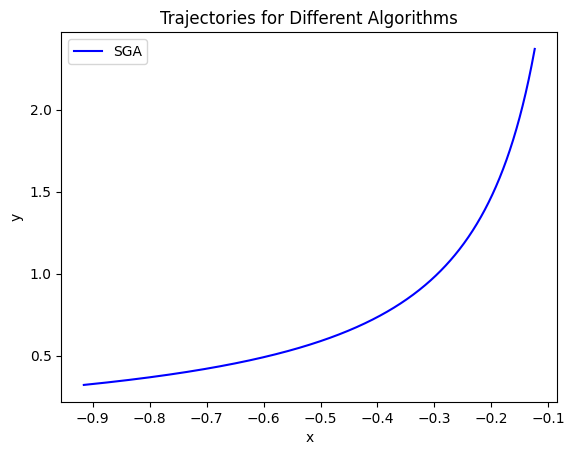

In [51]:
game_dims, game_Ls = potential_game()
th_initial = init_th(game_dims, 0.5)

th_out_x_sga, th_out_y_sga, losses_out_sga, distances_sga = run_and_plot('sga', th_initial, game_Ls,1000,0.001)
plt.plot(th_out_x_sga, th_out_y_sga,linestyle='-', color='b', label='SGA')

trajectory, distances_la = lookahead(th_initial,gradient_for_Hamiltonian, 1000, 0.1)

# Run and plot for 'eg'
th_out_x_eg, th_out_y_eg, losses_out_eg, distances_eg = run_and_plot('eg', th_initial, game_Ls)

# Run and plot for 'gd'
th_out_x_gd, th_out_y_gd, losses_out_gd, distances_gd  = run_and_plot('gd', th_initial, game_Ls)

th_out_x_sga_add, th_out_y_sga_add, losses_out_sga_add, distances_sga_add = run_and_plot('sga-add', th_initial, Ls)

plt.title('Trajectories for Different Algorithms')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

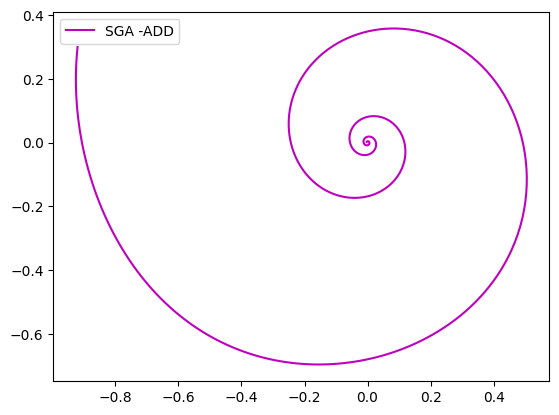

In [54]:
plt.plot(th_out_x_sga_add, th_out_y_sga_add,linestyle='-', color='m', label='SGA -ADD')
plt.legend()

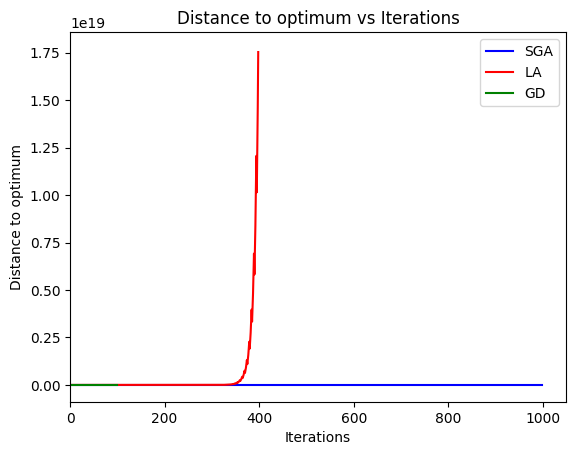

In [33]:
plt.plot(distances_sga, linestyle='-', color='b', label='SGA')
plt.plot(distances_la,  linestyle='-', color='r', label='LA')
plt.plot(distances_gd[:100],linestyle='-', color='g', label='GD')
# plt.plot(distances_eg,linestyle='-', color='y', label='EG')


plt.title("Distance to optimum vs Iterations")
plt.xlim(left=0)
plt.xlabel("Iterations")
plt.ylabel("Distance to optimum")
plt.legend()
plt.show()

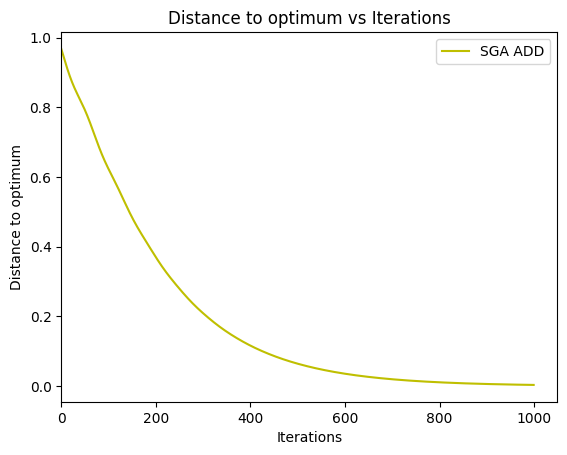

In [53]:
plt.plot(distances_sga_add,linestyle='-', color='y', label='SGA ADD')

plt.title("Distance to optimum vs Iterations")
plt.xlim(left=0)
plt.xlabel("Iterations")
plt.ylabel("Distance to optimum")
plt.legend()
plt.show()

We see that for potential games, SGA does not converge. This is a big drawback of the algorithm, that it fails to converge on pure min or pure maximization problems

**Note:** All other methods diverge as well. SGA diverges the slowest

**We now wish to investigate if we can somehow incorporate the rotational mechanics knowledge that the alignment operator brings about in the Lookahead mechanism**

# Section 3


We combine Lookahead method to allow for symplectic gradient adjustments. This makes the lookahead steps better than vanilla LA

## Lookahead (with Hamiltonian gradient knowledge)

In [17]:
def lookahead_with_sga(points, game_loss_func, num_iters, step_size,k=5, alpha=.5, solution =(0,0)):

  x, y = points[0],points[1]
  x_prev, y_prev = x.clone().detach(), y.clone().detach()
  trajectory = []
  distance_to_optimum =[]

  for i in range(num_iters):
    if i>0 and i%k ==0:
      x = (1-alpha)*x_prev + alpha * x
      y = (1-alpha)*y_prev + alpha * y
      #updating the lookahead step
      x_prev, y_prev = x.clone().detach(), y.clone().detach()


    th=[x,y]
    #regular gd step
    x_list, y_list, l_, distances_sga_la = run_and_plot('sga', th, game_loss_func, k, solution=solution)

    distance_to_optimum.append(distances_sga_la[-1])
    for x , y in zip(x_list,y_list):
      trajectory.append((x, y))

    x = torch.tensor([x_list[-1]], dtype = points[0].dtype)
    y = torch.tensor([y_list[-1]], dtype = points[0].dtype)

  return trajectory, distance_to_optimum

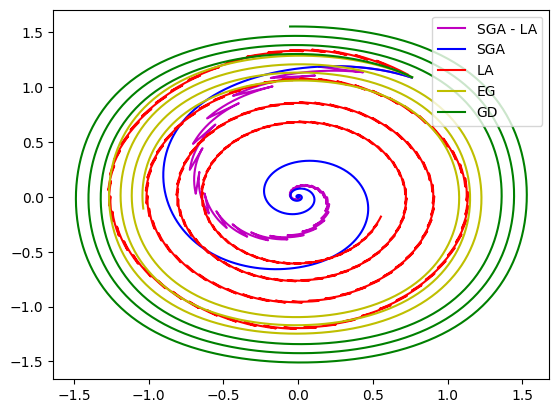

In [18]:
dims, Ls = matching_pennies()
std = 1
th_initial = init_th(dims, std)

start_time = time()
trajectory ,distances = lookahead_with_sga(th_initial, Ls, 1000, 0.01)
time_taken_la_sga = time() - start_time
time_la_sga = [i * (time_taken_la_sga/50) for i in range(1000)]
x_values = [point[0] for point in trajectory]
y_values = [point[1] for point in trajectory]
plt.plot(x_values, y_values, linestyle='-', color='m', label = 'SGA - LA')

start_time = time()
th_out_x_sga, th_out_y_sga, losses_out_sga, distances_sga = run_and_plot('sga', th_initial, Ls)
time_taken_sga = time() - start_time
time_sga = [i * (time_taken_sga/50) for i in range(1000)]
plt.plot(th_out_x_sga, th_out_y_sga,linestyle='-', color='b', label='SGA')

start_time = time()
trajectory, distances_la = lookahead(th_initial,gradient_func, 1000, 0.1)
time_taken_la = time() - start_time
time_la = [i * (time_taken_la/50) for i in range(1000)]
x_values = [point[0].item() for point in trajectory]
y_values = [point[1].item() for point in trajectory]
plt.plot(x_values, y_values, linestyle='-', color='r', label = 'LA')

start_time = time()
th_out_x_eg, th_out_y_eg, losses_out_eg, distances_eg = run_and_plot('eg', th_initial, Ls)
time_taken_eg = time() - start_time
time_eg = [i * (time_taken_eg/50) for i in range(1000)]
plt.plot(th_out_x_eg, th_out_y_eg, linestyle='-', color='y', label='EG')

start_time = time()
th_out_x_gd, th_out_y_gd, losses_out_gd, distances_gd  = run_and_plot('gd', th_initial, Ls)
time_taken_gd = time() - start_time
time_gd = [i * (time_taken_gd/50) for i in range(1000)]
plt.plot(th_out_x_gd, th_out_y_gd, linestyle='-', color='g', label='GD')

plt.legend()


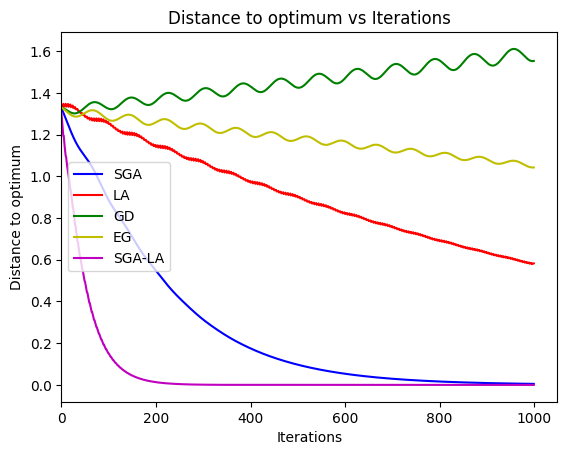

In [19]:
plt.plot(distances_sga, linestyle='-', color='b', label='SGA')
plt.plot(distances_la,  linestyle='-', color='r', label='LA')
plt.plot(distances_gd,linestyle='-', color='g', label='GD')
plt.plot(distances_eg,linestyle='-', color='y', label='EG')
plt.plot(distances, linestyle='-', color = 'm', label ="SGA-LA")

plt.title("Distance to optimum vs Iterations")
plt.xlim(left=0)
plt.xlabel("Iterations")
plt.ylabel("Distance to optimum")
plt.legend()
plt.show()

Text(0, 0.5, 'Distance from optimum')

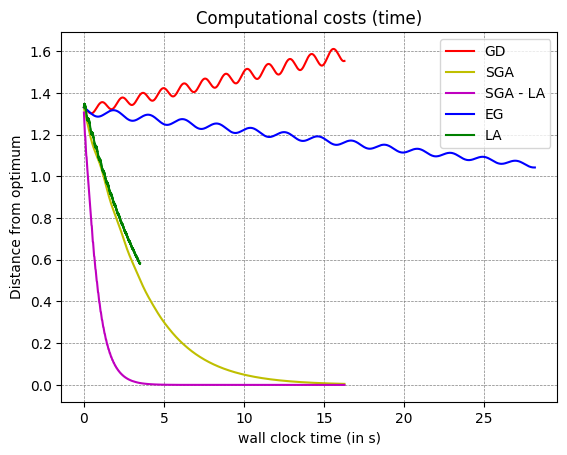

In [20]:
plt.plot(time_gd, distances_gd, label="GD", color ='r')
plt.plot(time_gd, distances_sga, label="SGA", color ='y')
plt.plot(time_gd, distances, label="SGA - LA", color ='m')
plt.plot(time_eg, distances_eg, label="EG", color = 'b')
plt.plot(time_la, distances_la, label="LA", color = 'g')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title("Computational costs (time)")
plt.xlabel('wall clock time (in s)')
plt.ylabel('Distance from optimum')

For this example, SGA-LA was also not even computationally expensive

# Section 4

## Comparison of SGA with other Hamiltonian Based Second Order Methods

We first consider the simple problem that we encountered in the first project.

We consider a simple game of the following form

Let $x\in\mathcal{R}$, $y\in\mathcal{R}$. Consider the following problem in $\mathcal{R}^2$:
$$
     \min_{x\in\mathcal{R}}\ \max_{y\in\mathcal{R}} \quad  a x+ b x \cdot y  +  a y    \,.
$$
where $a, b \in \mathcal{R}$

$$ \nabla f = \begin{bmatrix} \nabla_{x} f \\
    -\nabla_{y} f
\end{bmatrix} $$

$$ \nabla f = \begin{bmatrix} a + b y \\
    -a - b x
\end{bmatrix}$$

for simplicity we use a=b=1. The solution is at (-1,-1)

**NOTE**: This is a hamiltonian game.

### Hamiltonian Gradient Descent


The Hamiltonian function is $$H = \frac{\|\xi\|^2}{2}$$

Corresponding Hamiltonian operator is $$F_H(x) = \mathbf{J}^T \xi$$, where $\mathbf{J}$ is the Jacobian of the game.

HGD can be seen as simple GD applied to minimise the hamiltonian function

HGD may not find a stable fixed point.

### Consensus Optimization



CO proposes a gradient adjustment as follows

$$
\xi + \lambda \cdot \mathbf{J}^T \xi = \xi + \lambda \cdot \nabla \mathcal{H}
$$

In [21]:
def objective_func(x,y, a, b):
  return a*x + b*x*y +a*y

def gradient_func(x,y,a,b):
  x_grad = a+b*y
  y_grad = -a-b*x
  return x_grad, y_grad

def simple_hamiltonian_game(a, b):
  dims = [1,1]
  def Ls(th):
    x , y = th[0], th[1]
    L_1 = a*x + b*x*y +a*y
    L_2 = -L_1
    return [L_1, L_2]
  return dims, Ls

<ipython-input-7-eaefc1028497>:11: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  losses_out[k] = [loss.data.numpy() for loss in losses]


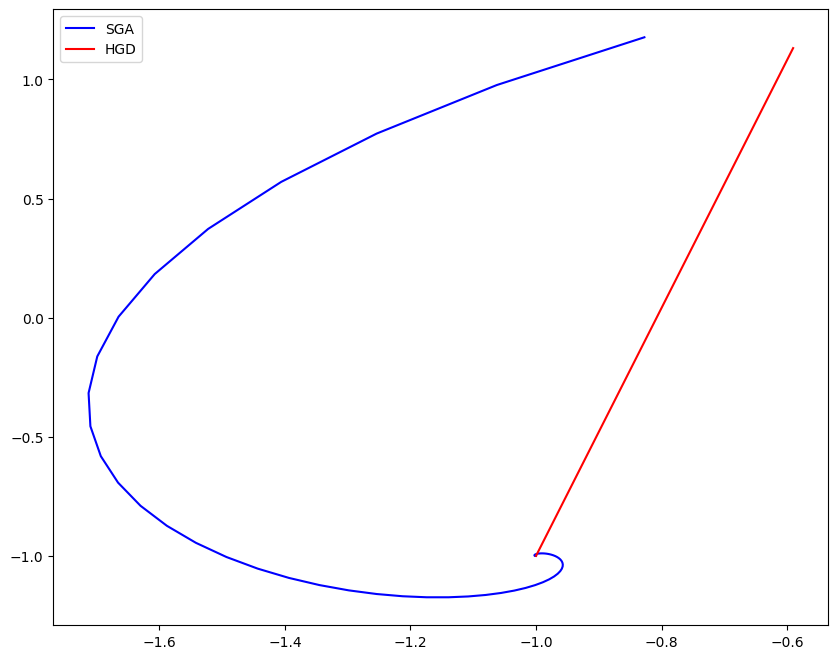

In [22]:
game_dims, game_Ls = simple_hamiltonian_game(1,1)
th_initial = init_th(game_dims, 1)
plt.figure(figsize=(10, 8))

th_out_x_sga, th_out_y_sga, losses_out_sga, distances_sga = run_and_plot('sga', th_initial, game_Ls, 100,solution=(-1,-1))
plt.plot(th_out_x_sga, th_out_y_sga,linestyle='-', color='b', label='SGA')

th_out_x_ham, th_out_y_ham, losses_out_ham, distances_ham = run_and_plot('ham', th_initial, game_Ls, 100,solution=(-1,-1))
plt.plot(th_out_x_ham, th_out_y_ham,linestyle='-', color='r', label='HGD')

plt.legend()
plt.show()

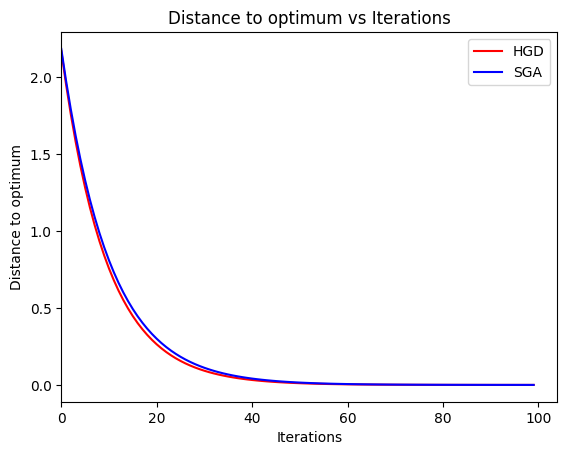

In [23]:
plt.plot(distances_ham, linestyle='-', color='r', label='HGD')
plt.plot(distances_sga,linestyle='-', color='b', label='SGA' )

plt.title("Distance to optimum vs Iterations")
plt.xlim(left=0)
plt.xlabel("Iterations")
plt.ylabel("Distance to optimum")
plt.legend()
plt.show()

Both attain comparable performances for this example.

**Note**: The Consensus optimizer(CO) operator is the same as the SGA operator as for this simple example, $$ \nabla \mathcal{H} = A $$ i.e. it is a hamiltonian game, where both work the same.

**We look at the following example to understand the merits and demerits of CO vs SGA**

Let us consider a simple potential game as follows

$$
l_1 (x,y) = l_2(x,y) = -\frac{k}{2} (x^2 + y^2)
$$
 with $k >> 0$

 In this case, we have the following parameters

 $$
\xi = -k \cdot \begin{bmatrix}
    x \\
    y \\
\end{bmatrix}
 $$ and
 $$
\mathbf{J} = - \begin{bmatrix}
    k && 0 \\
    0 && k \\
\end{bmatrix}
 $$

 The CO update step becomes
 $$
 \xi + \alpha \cdot \mathbf{J} \xi = k (\lambda k-1) \cdot \begin{bmatrix}
 x \\
 y \\
 \end{bmatrix}
 $$
 where $\alpha$ is a constant hyperparameter.

Clearly, this is not a minmax problem and the algorithm should diverge.

In [58]:
def simple_potential_game(k):
  dims = [1,1]
  def Ls(th):
    x , y = th[0], th[1]
    L_1 = -k/2 * (x**2 + y**2)
    L_2 = L_1
    return [L_1, L_2]
  return dims, Ls

<ipython-input-47-1e420fb22b31>:11: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  losses_out[k] = [loss.data.numpy() for loss in losses]


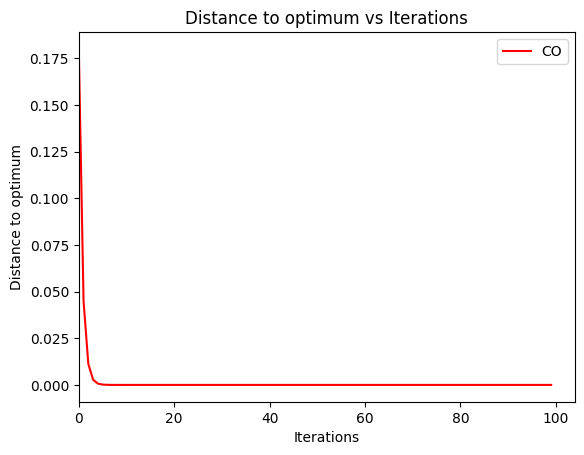

In [59]:
game_dims, game_Ls = simple_potential_game(15)
th_initial = init_th(game_dims, 0.5)

th_out_x_co, th_out_y_co, losses_out_co, distances_co = run_and_plot('co', th_initial, game_Ls, 100)

plt.plot(distances_co,linestyle='-', color='r', label='CO' )

plt.title("Distance to optimum vs Iterations")
plt.xlim(left=0)
plt.xlabel("Iterations")
plt.ylabel("Distance to optimum")
plt.legend()
plt.show()

<ipython-input-47-1e420fb22b31>:11: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  losses_out[k] = [loss.data.numpy() for loss in losses]


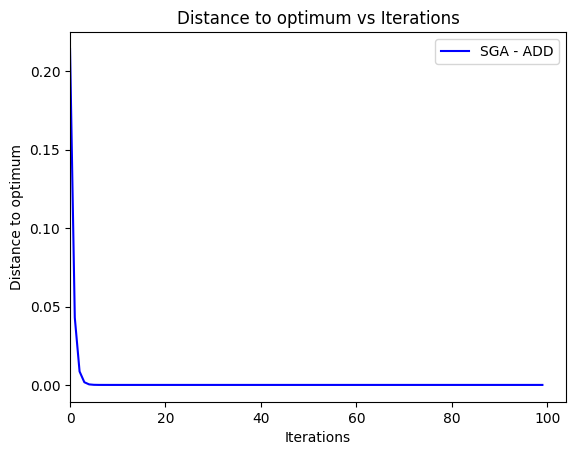

In [64]:
game_dims, game_Ls = simple_potential_game(4)
th_initial = init_th(game_dims, 0.5)

th_out_x_sga_add, th_out_y_sga_add, losses_out_sga_add, distances_sga_add = run_and_plot('sga-add', th_initial, game_Ls, 100)

plt.plot(distances_sga_add,linestyle='-', color='b', label='SGA - ADD' )

plt.title("Distance to optimum vs Iterations")
plt.xlim(left=0)
plt.xlabel("Iterations")
plt.ylabel("Distance to optimum")
plt.legend()
plt.show()

**We can see that the above function for CO converges to (0,0) even though it is a global maximum. SGA diverges for this simple potential game.**

SGA on the other hand diverges within 10 iterations

<ipython-input-7-eaefc1028497>:11: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  losses_out[k] = [loss.data.numpy() for loss in losses]


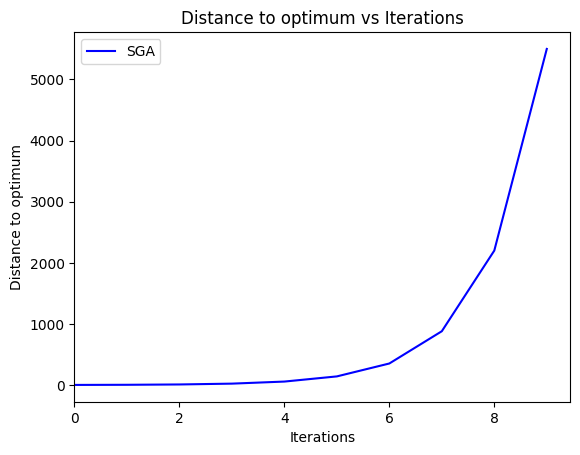

In [26]:
th_out_x_sga, th_out_y_sga, losses_out_sga, distances_sga = run_and_plot('sga', th_initial, game_Ls, 10)
plt.plot(distances_sga,linestyle='-', color='b', label='SGA' )
plt.title("Distance to optimum vs Iterations")
plt.xlim(left=0)
plt.xlabel("Iterations")
plt.ylabel("Distance to optimum")
plt.legend()
plt.show()

# Study Extension

In lieu of SGA's poor performance in potential games, and dealing with pure min/ pure max problems, we propose a small additional to the SGA operator to account for the non-rotational part of the mechanics. Namely, since only including the assymetric part of the Hessian is too strong, **we also include the symmetric part of the Hessian**. This slows down the algorithm in regular games, but helps it converge in the case of potential games. We explore it further in this section

### Improved Gradient Adjustment

We propose the following operator

\begin{align*}
\xi + \lambda_A \mathbf{A}^T\xi + \lambda_S S^T\xi
\end{align*}

where the symbols have their usual meanings,
$$
\lambda_S ← \frac{1}{d} sign(\langle \xi , \nabla \mathcal{H}>, \langle S^T \xi, \nabla \mathcal{H}\rangle )  
$$

We wished to investigate if including the symmetric part in a similar fashion as the assymetric part has any improvement in the performance of the algorithm in the case of potential games. We perform the following comparisons to highlight the same